In [2]:
import pandas as pd
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler

In [78]:
def parser(x):
    return pd.to_datetime(series['Month'],format = '%m/%d/%Y')
#     return pd.to_datetime(series['Month'])
series = pd.read_csv('shampoo-sales.csv', header=0, date_parser = parser)
series.set_index(['Month'], inplace = True)

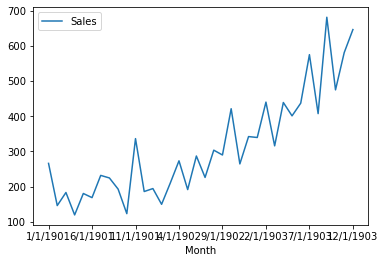

In [79]:
series.plot()
pyplot.show()

In [80]:
# Split the data into train and test
X = series.values
train, test = X[0:-12], X[-12:]

In [81]:
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # Make prediction
    predictions.append(history[-1])
    # Observation
    history.append(test[i])

https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/

All forecasts on the test dataset will be collected and an error score calculated to summarize the skill of the model. The root mean squared error (RMSE) will be used as it punishes large errors and results in a score that is in the same units as the forecast data, namely monthly shampoo sales.

<h2>LSTM Data Preparation</h2>
Before we can fit an LSTM model to the dataset, we must transform the data.

This section is broken down into three steps:

<li>Transform the time series into a supervised learning problem
<li>Transform the time series data so that it is stationary.
<li>Transform the observations to have a specific scale.
    
<h3>Transform Time Series to Supervised Learning</h3>
    More info: 

https://machinelearningmastery.com/time-series-forecasting-supervised-learning/
    
    
The LSTM model in Keras assumes that your data is divided into input (X) and output (y) components.

For a time series problem, we can achieve this by using the observation from the last time step (t-1) as the input and the observation at the current time step (t) as the output.

We can achieve this using the shift() function in Pandas that will push all values in a series down by a specified number places. We require a shift of 1 place, which will become the input variables. The time series as it stands will be the output variables.
    

<h3>Transform Time Series to Stationary</h3>
The Shampoo Sales dataset is not stationary.

This means that there is a structure in the data that is dependent on the time. Specifically, there is an increasing trend in the data.

Stationary data is easier to model and will very likely result in more skillful forecasts.

The trend can be removed from the observations, then added back to forecasts later to return the prediction to the original scale and calculate a comparable error score.

A standard way to remove a trend is by differencing the data. That is the observation from the previous time step (t-1) is subtracted from the current observation (t). This removes the trend and we are left with a difference series, or the changes to the observations from one time step to the next.

We can achieve this automatically using the diff() function in pandas. Alternatively, we can get finer grained control and write our own function to do this, which is preferred for its flexibility in this case.

Below is a function called difference() that calculates a differenced series. Note that the first observation in the series is skipped as there is no prior observation with which to calculate a differenced value.
    
<h3>Transform Time Series to Scale</h3>
Like other neural networks, LSTMs expect data to be within the scale of the activation function used by the network.

The default activation function for LSTMs is the hyperbolic tangent (tanh), which outputs values between -1 and 1. This is the preferred range for the time series data.

To make the experiment fair, the scaling coefficients (min and max) values must be calculated on the training dataset and applied to scale the test dataset and any forecasts. This is to avoid contaminating the experiment with knowledge from the test dataset, which might give the model a small edge.

We can transform the dataset to the range [-1, 1] using the MinMaxScaler class. Like other scikit-learn transform classes, it requires data provided in a matrix format with rows and columns. Therefore, we must reshape our NumPy arrays before transforming.

In [82]:
# Frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag = 1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis = 1)
    df.fillna(0, inplace = True)
    return df

supervised = timeseries_to_supervised(X, 1)
print(supervised.head())

       0      0
0    0.0  266.0
1  266.0  145.9
2  145.9  183.1
3  183.1  119.3
4  119.3  180.3


In [109]:
# Create a differenced series
def difference(dataset, interval = 1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

# Invert differenced value
def inverse_difference(history, yhat, interval = 1):
    return yhat + history[-interval]

# Transform to be stationary
differenced = difference(series['Sales'])
print(differenced.head())

# invert transformat
inverted = list()
for i in range(len(differenced)):
    value = inverse_difference(series['Sales'], differenced[i], len(series)-i)
    inverted.append(value)
inverted = pd.Series(inverted)
print(inverted.head())

0   -120.1
1     37.2
2    -63.8
3     61.0
4    -11.8
dtype: float64
0    145.9
1    183.1
2    119.3
3    180.3
4    168.5
dtype: float64


In [126]:
# Transform scale
X = series.values
X = X.reshape(len(X),1)
scaler = MinMaxScaler(feature_range = (-1, 1))
scaler = scaler.fit(X)
scaled_X = scaler.transform(X)
scaled_series = pd.Series(scaled_X[:, 0])
print(scaled_series.head())
# invert transform
inverted_X = scaler.inverse_transform(scaled_X)
inverted_series = pd.Series(inverted_X[:, 0])
print(inverted_series.head())

0   -0.478585
1   -0.905456
2   -0.773236
3   -1.000000
4   -0.783188
dtype: float64
0    266.0
1    145.9
2    183.1
3    119.3
4    180.3
dtype: float64


In [88]:
diff = list()
interval = 1
dataset = series['Sales']
for i in range(interval, len(dataset)):
    print(i)
    value = dataset[i] - dataset[i - interval]
    diff.append(value)
# pd.Series(diff)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


In [86]:
dataset.iloc[1]

Sales    145.9
Name: 1901-02-01 00:00:00, dtype: float64

In [87]:
series

,Sales
Month,
1/1/1901,266.0
2/1/1901,145.9
3/1/1901,183.1
4/1/1901,119.3
5/1/1901,180.3
6/1/1901,168.5
7/1/1901,231.8
8/1/1901,224.5
9/1/1901,192.8
